### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

C:\Users\csebastian\.conda\envs\BrainEN_v1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv("Data/energydata_complete.csv")
current_db['index'] = current_db.index
Index_col = "index"
target_col = "Appliances"

In [4]:
train_idx,test_idx = train_test_split(current_db[Index_col].unique(),test_size=0.25,random_state = 1)
current_db_train = current_db[current_db[Index_col].isin(train_idx)]
train_idx, val_idx = train_test_split(current_db_train[Index_col].unique(),test_size=0.37,random_state = 1)
current_db_val = current_db_train[current_db_train[Index_col].isin(val_idx)]
current_db_train = current_db[current_db[Index_col].isin(train_idx)]
current_db_test = current_db[current_db[Index_col].isin(test_idx)]

In [5]:
current_db_val_test = current_db_val.append(current_db_test)

In [6]:
len(current_db_train), len(current_db_val), len(current_db_test), len(current_db), len(current_db_train) + len(current_db_val) + len(current_db_test)

(9324, 5477, 4934, 19735, 19735)

In [7]:
X_train = current_db_train[list(current_db_train.columns.values[2:-1])]
y_train = current_db_train[target_col]

X_val = current_db_val[list(current_db_val.columns.values[2:-1])]
y_val = current_db_val[target_col]

X_test = current_db_test[list(current_db_test.columns.values[2:-1])]
y_test = current_db_test[target_col]

In [8]:
selected_columns = list(current_db_test.columns.values[2:-1])

In [9]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [10]:
current_db_train_val = current_db_train.append(current_db_val)

In [11]:
seeds = np.random.randint(1, 999999, 50)

## SHAPEffects 0.75-0.25

In [12]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_075_025 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.25, 0.75)
selected_features_shapeffects_075_025 = sorted(list(selected_features_shapeffects_075_025))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
2 features have been removed
['rv1', 'rv2', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['lights']
	24 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_1']
	23 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['T7']
	22 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_out']
	21 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['Windspeed']
	20 features left

Iteration 6
	Clasifying residuals
	Giving weights to features
	

In [13]:
feat_sel.best_mae

41.337756041736355

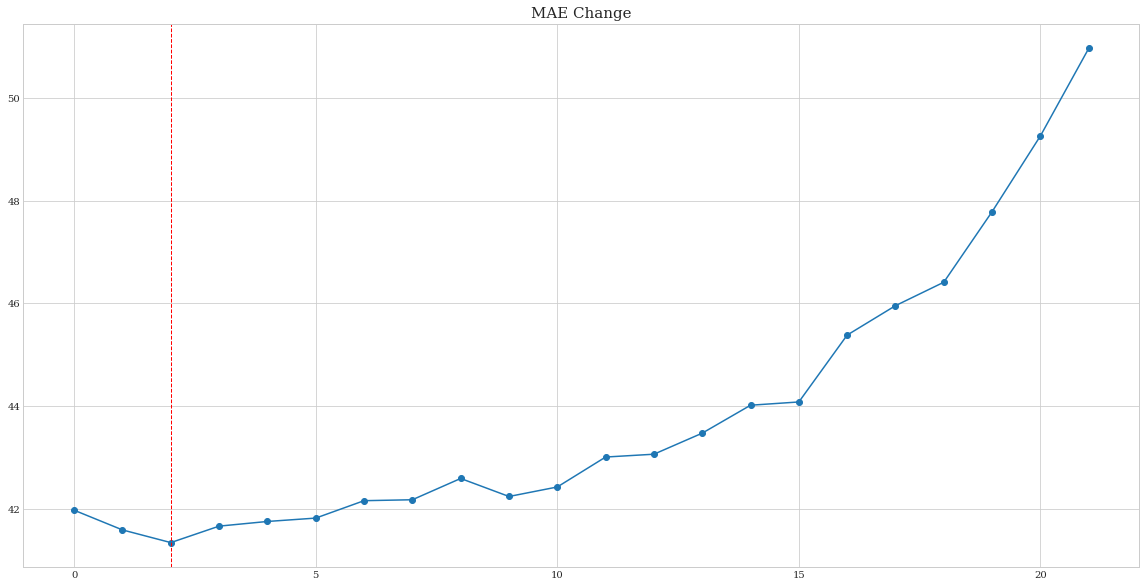

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [15]:
selected_features_shapeffects_075_025

['Press_mm_hg',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed']

In [16]:
dict_results_shapeffects_075_025 = {'rmse':[], 'mae':[], 'r2':[]}

In [17]:
X_test_shapeffects = X_test[selected_features_shapeffects_075_025]
X_train_shapeffects= X_train[selected_features_shapeffects_075_025]
X_val_shapeffects = X_val[selected_features_shapeffects_075_025]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_075_025["r2"].append(test_results["R2"])
    dict_results_shapeffects_075_025["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_075_025["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [18]:
results_shapeffects_075_025_df = pd.DataFrame(dict_results_shapeffects_075_025)
mean_shapeffects_075_025_test = results_shapeffects_075_025_df.mean()
std_shapeffects_075_025_test = results_shapeffects_075_025_df.std()
max_shapeffects_075_025_test = results_shapeffects_075_025_df.max()
min_shapeffects_075_025_test = results_shapeffects_075_025_df.min()

In [19]:
mean_shapeffects_075_025_test, std_shapeffects_075_025_test, max_shapeffects_075_025_test, min_shapeffects_075_025_test

(rmse    82.613837
 mae     42.569814
 r2       0.375597
 dtype: float64,
 rmse    0.335029
 mae     0.189054
 r2      0.005068
 dtype: float64,
 rmse    83.375908
 mae     43.011403
 r2       0.385244
 dtype: float64,
 rmse    81.973838
 mae     42.096426
 r2       0.364034
 dtype: float64)

## SHAPEffects 0.8-0.2

In [20]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_08_02 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.2, 0.8)
selected_features_shapeffects_08_02 = sorted(list(selected_features_shapeffects_08_02))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
2 features have been removed
['rv1', 'rv2', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['lights']
	24 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_1']
	23 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['T3']
	22 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_6']
	21 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_7']
	20 features left

Iteration 6
	Clasifying residuals
	Giving weights to features
	Selecti

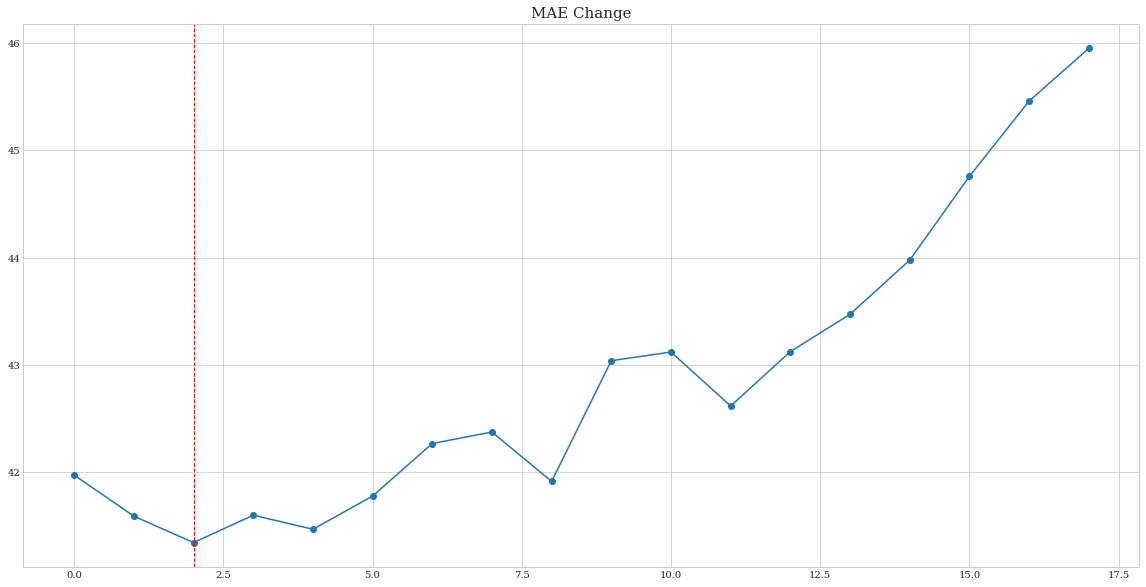

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [22]:
selected_features_shapeffects_08_02

['Press_mm_hg',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed']

In [23]:
dict_results_shapeffects_08_02 = {'rmse':[], 'mae':[], 'r2':[]}

In [24]:
X_test_shapeffects = X_test[selected_features_shapeffects_08_02]
X_train_shapeffects= X_train[selected_features_shapeffects_08_02]
X_val_shapeffects = X_val[selected_features_shapeffects_08_02]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_08_02["r2"].append(test_results["R2"])
    dict_results_shapeffects_08_02["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_08_02["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [25]:
results_shapeffects_08_02_df = pd.DataFrame(dict_results_shapeffects_08_02)
mean_shapeffects_08_02_test = results_shapeffects_08_02_df.mean()
std_shapeffects_08_02_test = results_shapeffects_08_02_df.std()
max_shapeffects_08_02_test = results_shapeffects_08_02_df.max()
min_shapeffects_08_02_test = results_shapeffects_08_02_df.min()

In [26]:
mean_shapeffects_08_02_test, std_shapeffects_08_02_test, max_shapeffects_08_02_test, min_shapeffects_08_02_test

(rmse    82.613837
 mae     42.569814
 r2       0.375597
 dtype: float64,
 rmse    0.335029
 mae     0.189054
 r2      0.005068
 dtype: float64,
 rmse    83.375908
 mae     43.011403
 r2       0.385244
 dtype: float64,
 rmse    81.973838
 mae     42.096426
 r2       0.364034
 dtype: float64)

## SHAPEffects 0.85-0.15

In [27]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_085_015 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.15, 0.85)
selected_features_shapeffects_085_015 = sorted(list(selected_features_shapeffects_085_015))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
2 features have been removed
['rv1', 'rv2', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['lights']
	24 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_1']
	23 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_out']
	22 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_6']
	21 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['Windspeed']
	20 features left

Iteration 6
	Clasifying residuals
	Giving weights to features

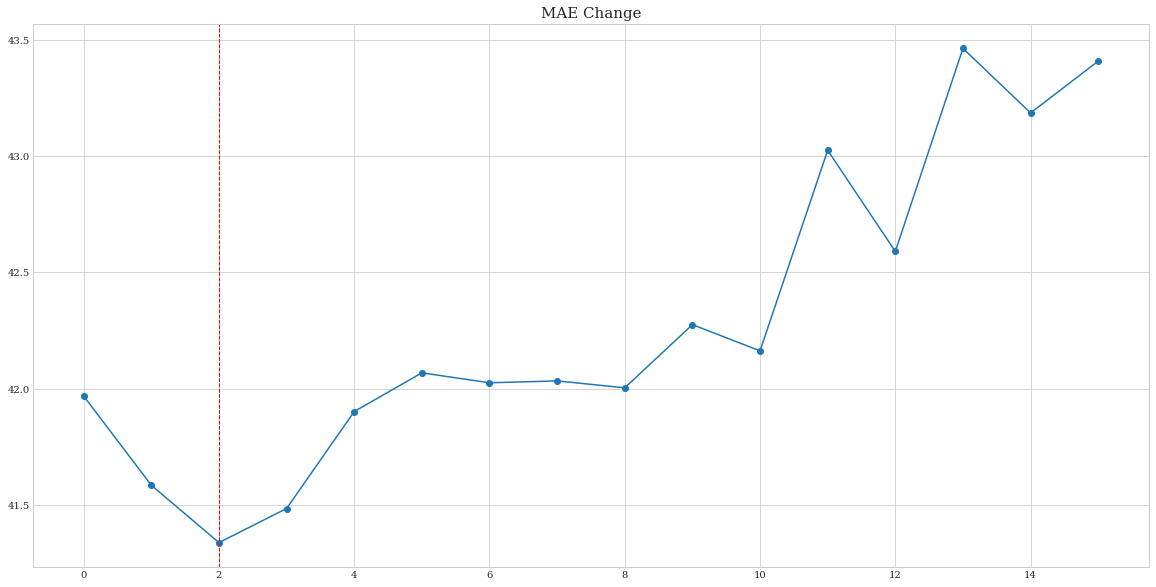

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [29]:
selected_features_shapeffects_085_015

['Press_mm_hg',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed']

In [30]:
dict_results_shapeffects_085_015 = {'rmse':[], 'mae':[], 'r2':[]}

In [31]:
X_test_shapeffects = X_test[selected_features_shapeffects_085_015]
X_train_shapeffects= X_train[selected_features_shapeffects_085_015]
X_val_shapeffects = X_val[selected_features_shapeffects_085_015]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_085_015["r2"].append(test_results["R2"])
    dict_results_shapeffects_085_015["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_085_015["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [32]:
results_shapeffects_085_015_df = pd.DataFrame(dict_results_shapeffects_085_015)
mean_shapeffects_085_015_test = results_shapeffects_085_015_df.mean()
std_shapeffects_085_015_test = results_shapeffects_085_015_df.std()
max_shapeffects_085_015_test = results_shapeffects_085_015_df.max()
min_shapeffects_085_015_test = results_shapeffects_085_015_df.min()

In [33]:
mean_shapeffects_085_015_test, std_shapeffects_085_015_test, max_shapeffects_085_015_test, min_shapeffects_085_015_test

(rmse    82.613837
 mae     42.569814
 r2       0.375597
 dtype: float64,
 rmse    0.335029
 mae     0.189054
 r2      0.005068
 dtype: float64,
 rmse    83.375908
 mae     43.011403
 r2       0.385244
 dtype: float64,
 rmse    81.973838
 mae     42.096426
 r2       0.364034
 dtype: float64)

## SHAPEffects 0.9-0.1

In [34]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_09_01 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.1, 0.9)
selected_features_shapeffects_09_01 = sorted(list(selected_features_shapeffects_09_01))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
2 features have been removed
['rv1', 'rv2', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	0 features have been removed
	25 features left
25 features have been selected out of 28


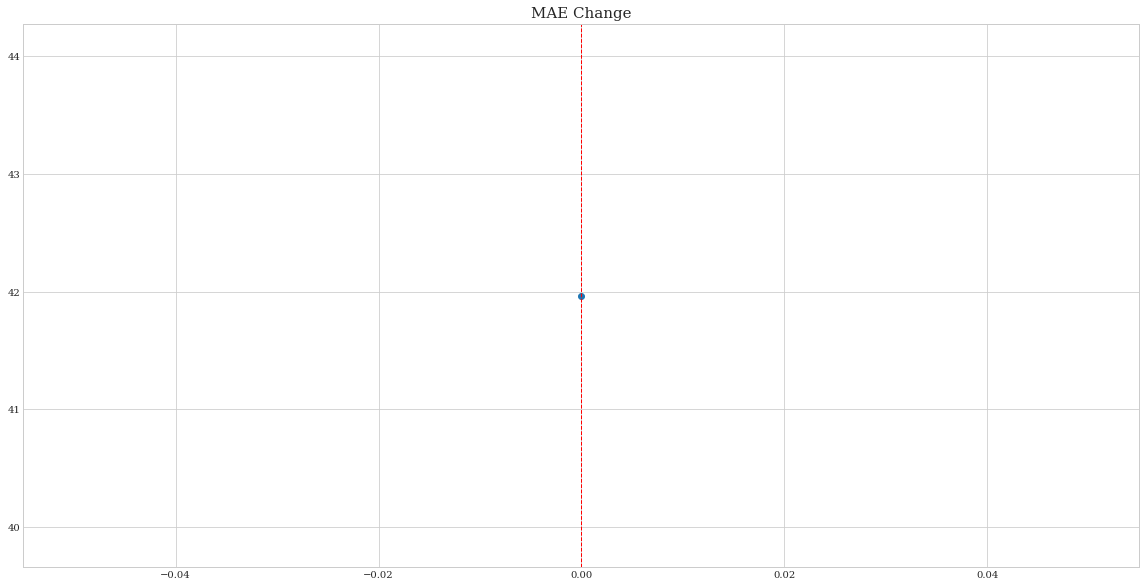

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [36]:
selected_features_shapeffects_09_01

['Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed',
 'lights']

In [37]:
dict_results_shapeffects_09_01 = {'rmse':[], 'mae':[], 'r2':[]}

In [38]:
X_test_shapeffects = X_test[selected_features_shapeffects_09_01]
X_train_shapeffects= X_train[selected_features_shapeffects_09_01]
X_val_shapeffects = X_val[selected_features_shapeffects_09_01]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_09_01["r2"].append(test_results["R2"])
    dict_results_shapeffects_09_01["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_09_01["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [39]:
results_shapeffects_09_01_df = pd.DataFrame(dict_results_shapeffects_09_01)
mean_shapeffects_09_01_test = results_shapeffects_09_01_df.mean()
std_shapeffects_09_01_test = results_shapeffects_09_01_df.std()
max_shapeffects_09_01_test = results_shapeffects_09_01_df.max()
min_shapeffects_09_01_test = results_shapeffects_09_01_df.min()

In [40]:
mean_shapeffects_09_01_test, std_shapeffects_09_01_test, max_shapeffects_09_01_test, min_shapeffects_09_01_test

(rmse    81.940827
 mae     42.355304
 r2       0.385728
 dtype: float64,
 rmse    0.351559
 mae     0.212130
 r2      0.005269
 dtype: float64,
 rmse    82.586724
 mae     42.778391
 r2       0.396864
 dtype: float64,
 rmse    81.195394
 mae     41.802593
 r2       0.376017
 dtype: float64)

## SHAPEffects 0.95-0.05

In [41]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_095_005 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.05, 0.95)
selected_features_shapeffects_095_005 = sorted(list(selected_features_shapeffects_095_005))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
3 features have been removed
['Visibility', 'rv1', 'rv2', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_2']
	23 features left

Iteration 2
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_out']
	22 features left

Iteration 3
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_7']
	21 features left

Iteration 4
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['Tdewpoint']
	20 features left

Iteration 5
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['RH_8']
	19 features left

Iteration 6
	Clasifying residuals
	Giving weights

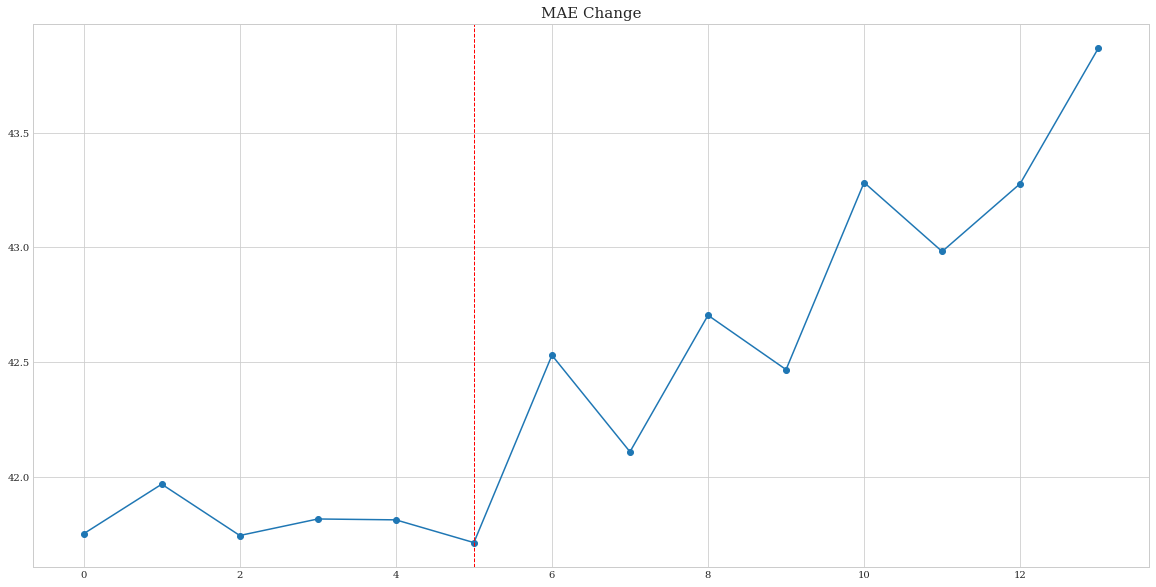

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("MAE Change")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [43]:
selected_features_shapeffects_095_005

['Press_mm_hg',
 'RH_1',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_9',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Windspeed',
 'lights']

In [44]:
dict_results_shapeffects_095_005 = {'rmse':[], 'mae':[], 'r2':[]}

In [45]:
X_test_shapeffects = X_test[selected_features_shapeffects_095_005]
X_train_shapeffects= X_train[selected_features_shapeffects_095_005]
X_val_shapeffects = X_val[selected_features_shapeffects_095_005]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_095_005["r2"].append(test_results["R2"])
    dict_results_shapeffects_095_005["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_095_005["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [46]:
results_shapeffects_095_005_df = pd.DataFrame(dict_results_shapeffects_095_005)
mean_shapeffects_095_005_test = results_shapeffects_095_005_df.mean()
std_shapeffects_095_005_test = results_shapeffects_095_005_df.std()
max_shapeffects_095_005_test = results_shapeffects_095_005_df.max()
min_shapeffects_095_005_test = results_shapeffects_095_005_df.min()

In [47]:
mean_shapeffects_095_005_test, std_shapeffects_095_005_test, max_shapeffects_095_005_test, min_shapeffects_095_005_test

(rmse    82.939156
 mae     43.215691
 r2       0.370665
 dtype: float64,
 rmse    0.407251
 mae     0.193148
 r2      0.006178
 dtype: float64,
 rmse    84.040078
 mae     43.795774
 r2       0.384872
 dtype: float64,
 rmse    81.998599
 mae     42.822165
 r2       0.353862
 dtype: float64)

## PowerSHAP

In [48]:
selector = PowerShap(
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123),
    power_iterations=10,automatic=True, limit_automatic=10,verbose=True,target_col=target_col,index_col=Index_col,
)
selector.fit(current_db_train_val[list(selected_columns)], current_db_train_val[target_col])

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.



10 iterations were already sufficient as only 6 iterations were required for the current  power_alpha = 0.01.
Done!


PowerShap(model=<catboost.core.CatBoostRegressor object at 0x000002B88AB53AF0>,
          verbose=True)

In [49]:
t = selector._processed_shaps_df
selected_features_powershap = t[(t.p_value<0.01)].index.values
selected_features_powershap

array(['RH_1', 'lights', 'RH_2', 'T6', 'T3', 'RH_8', 'T4', 'RH_6', 'RH_3',
       'T1', 'RH_5', 'RH_7', 'RH_4', 'RH_out', 'T9', 'T8', 'T5', 'T2',
       'T7', 'Windspeed', 'Tdewpoint', 'Press_mm_hg', 'T_out', 'RH_9'],
      dtype=object)

In [50]:
selected_features_powershap = sorted(selected_features_powershap)

In [12]:
selected_features_powershap = sorted(['RH_1', 'lights', 'RH_2', 'T6', 'T3', 'RH_8', 'T4', 'RH_6', 'RH_3',
       'T1', 'RH_5', 'RH_7', 'RH_4', 'RH_out', 'T9', 'T8', 'T5', 'T2',
       'T7', 'Windspeed', 'Tdewpoint', 'Press_mm_hg', 'T_out', 'RH_9'])

In [13]:
dict_results_powershap = {'rmse':[], 'mae':[], 'r2':[]}

In [14]:
X_test_powershap = X_test[selected_features_powershap]
X_train_powershap = X_train[selected_features_powershap]
X_val_powershap = X_val[selected_features_powershap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_powershap, y_train,
        eval_set=(X_val_powershap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_powershap), print_bool=False)
    
    dict_results_powershap["r2"].append(test_results["R2"])
    dict_results_powershap["rmse"].append(test_results["RMSE"])
    dict_results_powershap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [15]:
results_powershap_df = pd.DataFrame(dict_results_powershap)
mean_powershap_test = results_powershap_df.mean()
std_powershap_test = results_powershap_df.std()
max_powershap_test = results_powershap_df.max()
min_powershap_test = results_powershap_df.min()

In [16]:
mean_powershap_test, std_powershap_test, max_powershap_test, min_powershap_test

(rmse    81.848339
 mae     42.239443
 r2       0.387110
 dtype: float64,
 rmse    0.405236
 mae     0.232121
 r2      0.006071
 dtype: float64,
 rmse    82.787452
 mae     42.744082
 r2       0.399485
 dtype: float64,
 rmse    81.018772
 mae     41.709519
 r2       0.372980
 dtype: float64)

## BorutaSHAP

In [56]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)


24 attributes confirmed important: ['RH_4', 'RH_9', 'RH_out', 'T1', 'T2', 'lights', 'T_out', 'RH_3', 'RH_2', 'RH_7', 'RH_1', 'Windspeed', 'T3', 'RH_5', 'T6', 'T7', 'T8', 'T9', 'RH_8', 'Tdewpoint', 'T5', 'Press_mm_hg', 'RH_6', 'T4']
3 attributes confirmed unimportant: ['rv1', 'rv2', 'Visibility']
0 tentative attributes remains: []


In [57]:
subset = Feature_Selector.Subset()
selected_features_borutashap = sorted(subset.columns.values)
selected_features_borutashap

['Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Windspeed',
 'lights']

In [17]:
selected_features_borutashap = sorted(['RH_4', 'RH_9', 'RH_out', 'T1', 'T2', 'lights', 'T_out', 'RH_3', 'RH_2', 'RH_7', 'RH_1', 'Windspeed', 'T3', 'RH_5', 'T6', 'T7', 'T8', 'T9', 'RH_8', 'Tdewpoint', 'T5', 'Press_mm_hg', 'RH_6', 'T4'])

In [18]:
dict_results_borutashap = {'rmse':[], 'mae':[], 'r2':[]}

In [19]:
X_test_borutashap = X_test[selected_features_borutashap]
X_train_borutashap = X_train[selected_features_borutashap]
X_val_borutashap = X_val[selected_features_borutashap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_borutashap, y_train,
        eval_set=(X_val_borutashap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_borutashap), print_bool=False)
    
    dict_results_borutashap["r2"].append(test_results["R2"])
    dict_results_borutashap["rmse"].append(test_results["RMSE"])
    dict_results_borutashap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [20]:
results_borutashap_df = pd.DataFrame(dict_results_borutashap)
mean_borutashap_test = results_borutashap_df.mean()
std_borutashap_test = results_borutashap_df.std()
max_borutashap_test = results_borutashap_df.max()
min_borutashap_test = results_borutashap_df.min()

In [21]:
mean_borutashap_test, std_borutashap_test, max_borutashap_test, min_borutashap_test

(rmse    81.848339
 mae     42.239443
 r2       0.387110
 dtype: float64,
 rmse    0.405236
 mae     0.232121
 r2      0.006071
 dtype: float64,
 rmse    82.787452
 mae     42.744082
 r2       0.399485
 dtype: float64,
 rmse    81.018772
 mae     41.709519
 r2       0.372980
 dtype: float64)

## Shapicant

In [63]:
# LightGBM in RandomForest-like mode (with rows subsampling), without columns subsampling
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)


# This is the class (not its instance) of SHAP's TreeExplainer
explainer_type = shap.TreeExplainer

# Use PandasSelector with 100 iterations
selector = shapicant.PandasSelector(model, explainer_type, random_state=42)

# Run the feature selection
# If we provide a validation set, SHAP values are computed on it, otherwise they are computed on the training set
# We can also provide additional parameters to the underlying estimator's fit method through estimator_params
selector.fit(X_train, y_train, X_validation=X_val)#, estimator_params={"categorical_feature": None})

# Just get the features list
selected_features = selector.get_features()

# We can also get the p-values as pandas Series
p_values = selector.p_values_

selected_features_shapicant = sorted(np.array(selected_features))

Computing null SHAP values: 100%|████████████████████████████████████████████████████| 100/100 [12:33<00:00,  7.53s/it]


In [64]:
selected_features_shapicant

['Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_6',
 'RH_out',
 'T1',
 'T3',
 'T4',
 'Windspeed',
 'lights']

In [22]:
selected_features_shapicant = sorted(['Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_6',
 'RH_out',
 'T1',
 'T3',
 'T4',
 'Windspeed',
 'lights'])

In [23]:
dict_results_shapicant = {'rmse':[], 'mae':[], 'r2':[]}

In [24]:
X_test_shapicant = X_test[selected_features_shapicant]
X_train_shapicant= X_train[selected_features_shapicant]
X_val_shapicant = X_val[selected_features_shapicant]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapicant, y_train,
        eval_set=(X_val_shapicant, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapicant), print_bool=False)
    
    dict_results_shapicant["r2"].append(test_results["R2"])
    dict_results_shapicant["rmse"].append(test_results["RMSE"])
    dict_results_shapicant["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [25]:
results_shapicant_df = pd.DataFrame(dict_results_shapicant)
mean_shapicant_test = results_shapicant_df.mean()
std_shapicant_test = results_shapicant_df.std()
max_shapicant_test = results_shapicant_df.max()
min_shapicant_test = results_shapicant_df.min()

In [26]:
mean_shapicant_test, std_shapicant_test, max_shapicant_test, min_shapicant_test

(rmse    84.736612
 mae     45.044876
 r2       0.343097
 dtype: float64,
 rmse    0.333896
 mae     0.221856
 r2      0.005180
 dtype: float64,
 rmse    85.566843
 mae     45.505549
 r2       0.354568
 dtype: float64,
 rmse    83.994154
 mae     44.662541
 r2       0.330172
 dtype: float64)

# Results

In [70]:
nombres = ['PowerSHAP', 'BorutaSHAP', 'Shapicant', 'SHAPEffects_075_025', 'SHAPEffects_08_02', 'SHAPEffects_085_015', 'SHAPEffects_09_01', 'SHAPEffects_095_005']

## MAE

In [71]:
resultados_mae_mean = [mean_powershap_test['mae'], mean_borutashap_test['mae'], mean_shapicant_test['mae'], mean_shapeffects_075_025_test['mae'], mean_shapeffects_08_02_test['mae'], mean_shapeffects_085_015_test['mae'], mean_shapeffects_09_01_test['mae'], mean_shapeffects_095_005_test['mae']]
resultados_mae_std = [std_powershap_test['mae'], std_borutashap_test['mae'], std_shapicant_test['mae'], std_shapeffects_075_025_test['mae'], std_shapeffects_08_02_test['mae'], std_shapeffects_085_015_test['mae'], std_shapeffects_09_01_test['mae'], std_shapeffects_095_005_test['mae']]
resultados_mae_max = [max_powershap_test['mae'], max_borutashap_test['mae'], max_shapicant_test['mae'], max_shapeffects_075_025_test['mae'], max_shapeffects_08_02_test['mae'], max_shapeffects_085_015_test['mae'], max_shapeffects_09_01_test['mae'], max_shapeffects_095_005_test['mae']]
resultados_mae_min = [min_powershap_test['mae'], min_borutashap_test['mae'], min_shapicant_test['mae'], min_shapeffects_075_025_test['mae'], min_shapeffects_08_02_test['mae'], min_shapeffects_085_015_test['mae'], min_shapeffects_09_01_test['mae'], min_shapeffects_095_005_test['mae']]

(40.0, 46.0)

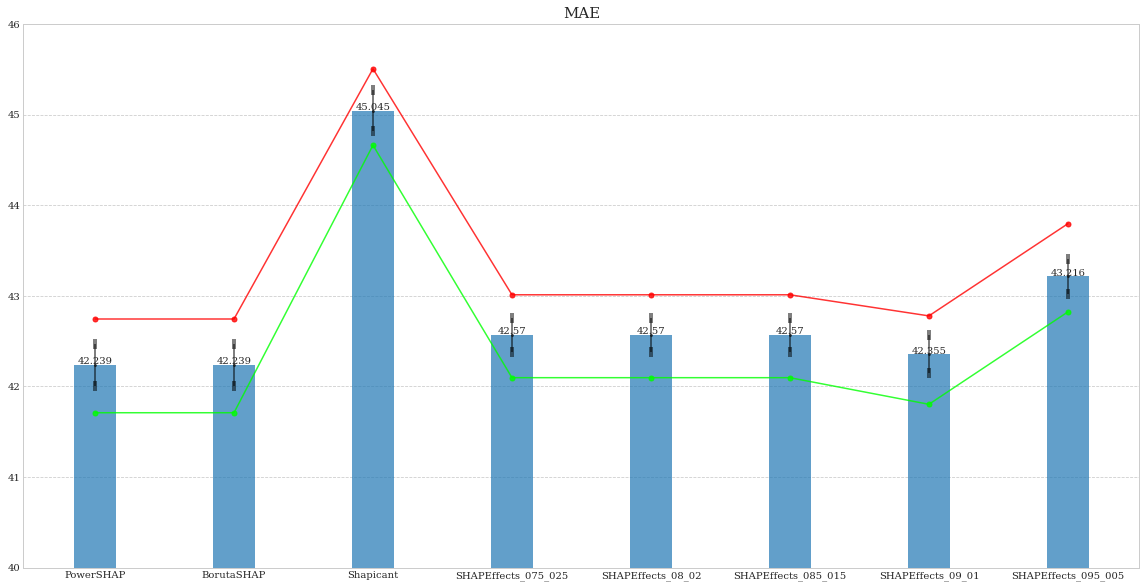

In [72]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([40, 46])

## RMSE

In [73]:
resultados_rmse_mean = [mean_powershap_test['rmse'], mean_borutashap_test['rmse'], mean_shapicant_test['rmse'], mean_shapeffects_075_025_test['rmse'], mean_shapeffects_08_02_test['rmse'], mean_shapeffects_085_015_test['rmse'], mean_shapeffects_09_01_test['rmse'], mean_shapeffects_095_005_test['rmse']]
resultados_rmse_std = [std_powershap_test['rmse'], std_borutashap_test['rmse'], std_shapicant_test['rmse'], std_shapeffects_075_025_test['rmse'], std_shapeffects_08_02_test['rmse'], std_shapeffects_085_015_test['rmse'], std_shapeffects_09_01_test['rmse'], std_shapeffects_095_005_test['rmse']]
resultados_rmse_max = [max_powershap_test['rmse'], max_borutashap_test['rmse'], max_shapicant_test['rmse'], max_shapeffects_075_025_test['rmse'], max_shapeffects_08_02_test['rmse'], max_shapeffects_085_015_test['rmse'], max_shapeffects_09_01_test['rmse'], max_shapeffects_095_005_test['rmse']]
resultados_rmse_min = [min_powershap_test['rmse'], min_borutashap_test['rmse'], min_shapicant_test['rmse'], min_shapeffects_075_025_test['rmse'], min_shapeffects_08_02_test['rmse'], min_shapeffects_085_015_test['rmse'], min_shapeffects_09_01_test['rmse'], min_shapeffects_095_005_test['rmse']]

(80.0, 86.0)

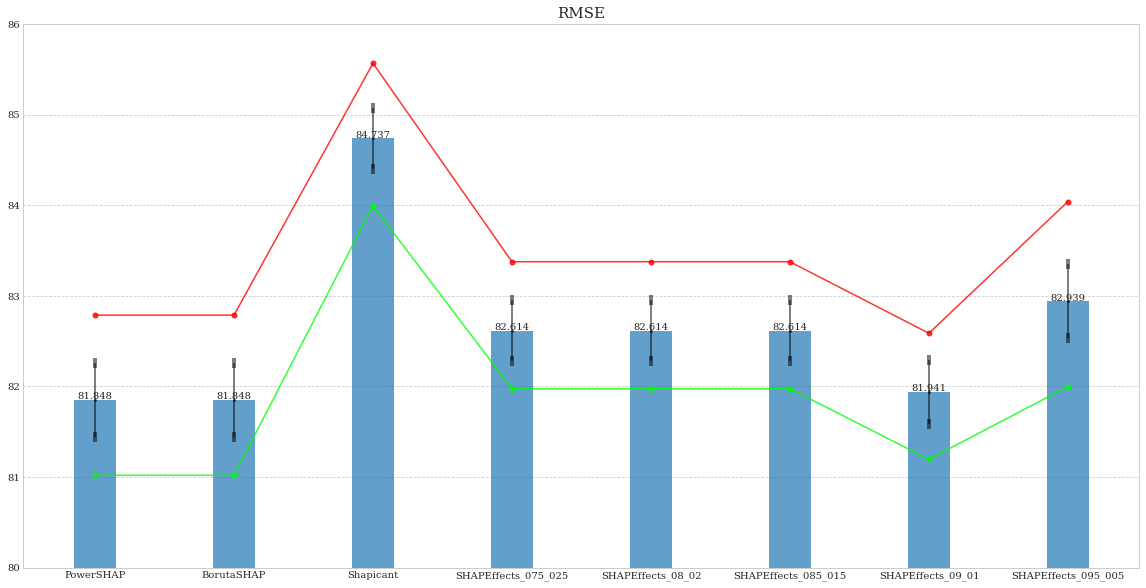

In [74]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([80, 86])

## R2

In [75]:
resultados_r2_mean = [mean_powershap_test['r2'], mean_borutashap_test['r2'], mean_shapicant_test['r2'], mean_shapeffects_075_025_test['r2'], mean_shapeffects_08_02_test['r2'], mean_shapeffects_085_015_test['r2'], mean_shapeffects_09_01_test['r2'], mean_shapeffects_095_005_test['r2']]
resultados_r2_std = [std_powershap_test['r2'], std_borutashap_test['r2'], std_shapicant_test['r2'], std_shapeffects_075_025_test['r2'], std_shapeffects_08_02_test['r2'], std_shapeffects_085_015_test['r2'], std_shapeffects_09_01_test['r2'], std_shapeffects_095_005_test['r2']]
resultados_r2_max = [max_powershap_test['r2'], max_borutashap_test['r2'], max_shapicant_test['r2'], max_shapeffects_075_025_test['r2'], max_shapeffects_08_02_test['r2'], max_shapeffects_085_015_test['r2'], max_shapeffects_09_01_test['r2'], max_shapeffects_095_005_test['r2']]
resultados_r2_min = [min_powershap_test['r2'], min_borutashap_test['r2'], min_shapicant_test['r2'], min_shapeffects_075_025_test['r2'], min_shapeffects_08_02_test['r2'], min_shapeffects_085_015_test['r2'], min_shapeffects_09_01_test['r2'], min_shapeffects_095_005_test['r2']]

In [76]:
resultados_r2_max, resultados_r2_min

([0.39948504396234763,
  0.39948504396234763,
  0.3545677857610604,
  0.38524360248334777,
  0.38524360248334777,
  0.38524360248334777,
  0.39686393577813384,
  0.38487216155522674],
 [0.37297978593329784,
  0.37297978593329784,
  0.33017164086078477,
  0.364034334587526,
  0.364034334587526,
  0.364034334587526,
  0.3760166550502072,
  0.35386180918552557])

(0.3, 0.5)

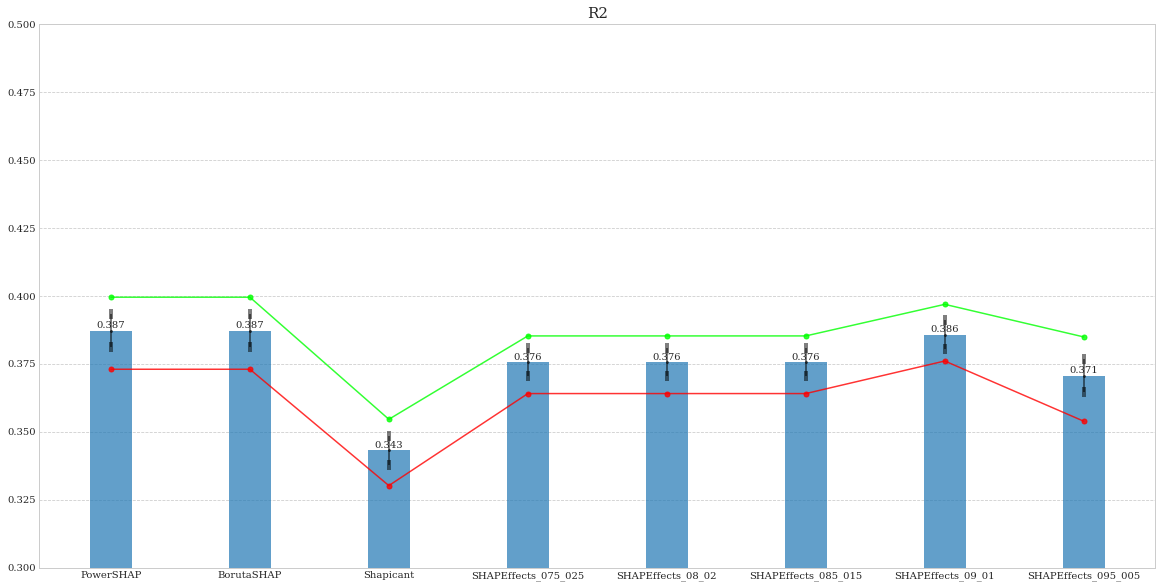

In [77]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0.3, 0.5])

## Number of variables

In [78]:
n_var = [len(selected_features_powershap), len(selected_features_borutashap), len(selected_features_shapicant), len(selected_features_shapeffects_075_025), len(selected_features_shapeffects_08_02), len(selected_features_shapeffects_085_015), len(selected_features_shapeffects_09_01), len(selected_features_shapeffects_095_005)]

(0.0, 28.0)

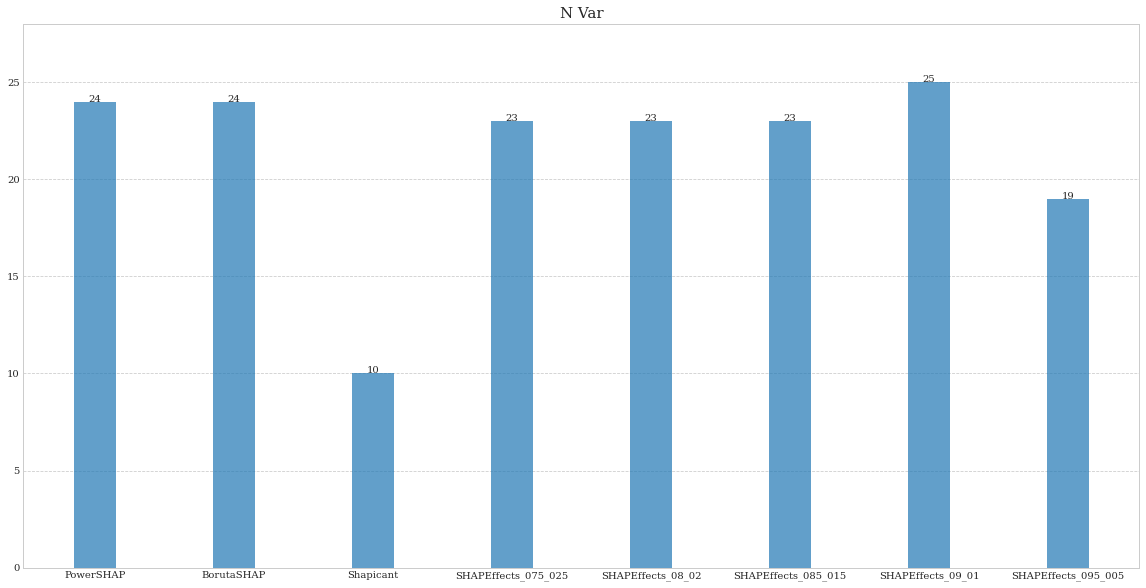

In [79]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 28])